### 1. Library Imports

In this section, we import all the necessary libraries for data manipulation, visualization, and fuzzy matching.  
The dataset is then loaded from a local CSV file for further processing.

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from fuzzywuzzy import fuzz

In [340]:
df = pd.read_csv("C:\Data Science Projects\Veridion_Task\presales_data_sample.csv")

### 2. Preparing the data

To ensure consistency and minimize noise in string fields, we apply a cleaning function across all text columns in the dataset.  
This includes:

- Lowercasing all text
- Removing leading/trailing whitespaces
- Stripping unwanted special characters (e.g., punctuation)

The cleaning process ensures that matching and further processing steps are more robust and reliable.

In [341]:
def clean_all_strings(df: pd.DataFrame, keep_pipe: bool = True) -> pd.DataFrame:
    
    df_cleaned = df.copy()

    pattern = r'[^a-z0-9\s|]' if keep_pipe else r'[^a-z0-9\s]'

    for col in df_cleaned.select_dtypes(include='object').columns:
        df_cleaned[col] = df_cleaned[col].astype(str).str.lower().str.strip()
        df_cleaned[col] = df_cleaned[col].apply(lambda x: re.sub(pattern, '', x))

    return df_cleaned

In [342]:
df_cleaned = clean_all_strings(df)

In [343]:
df_cleaned.head(10)

,input_row_key,input_company_name,input_main_country_code,input_main_country,input_main_region,input_main_city,input_main_postcode,input_main_street,input_main_street_number,veridion_id,...,twitter_url,instagram_url,linkedin_url,ios_app_url,android_app_url,youtube_url,tiktok_url,technologies,created_at,last_updated_at
0,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,26e2221093e511ebb9978dd98d09cf25,...,nan,nan,httpwwwlinkedincomcompanymnetservicesprivateli...,nan,nan,nan,NaN,web servers apache http server 2 | javascript...,20200225t144751000z,20241129t041800109z
1,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,010046411dd811ef9268316fc8e174dd,...,nan,nan,nan,nan,nan,nan,NaN,nan,20240529t162411019z,20250420t150324026z
2,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,8266efc113e711ecaa147bf90e1e10f1,...,httpstwittercomnetwork24seven20,nan,httpswwwlinkedincomcompany516336122020,nan,nan,nan,NaN,nan,20210912t052848000z,20250318t230837059z
3,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,0183f0b293e511ebbe5a4f810ab55f2e,...,httpstwittercomemeriosoft,nan,httpswwwlinkedincomcompanyemeriosoft,nan,nan,nan,NaN,miscellaneous popper | maps google maps | prog...,20200503t123322000z,20250331t161658462z
4,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,87bb7cde93e411eb84743bbe2d07207d,...,httpstwittercomasiaticpr,httpswwwinstagramcomasiaticpublicrelations,httpswwwlinkedincomcompanyasiaticpublicrelations,nan,nan,httpswwwyoutubecomchanneluclkghvhiuou4kegleoixg,NaN,miscellaneous babel | javascript libraries cor...,20200219t035825000z,20241125t113547963z
5,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,8b99ef8393e411ebb9978dd98d09cf25,...,nan,nan,httpswwwlinkedincomcompany2operateas,nan,nan,nan,NaN,javascript libraries lodash | javascript libra...,20200217t155651000z,20250328t151632101z
6,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,92d0f2d4058111ec8c143f55c5871ced,...,httpstwittercomco2operate,nan,nan,nan,nan,nan,NaN,miscellaneous rss | cms wordpress 597 | javas...,20210822t235137000z,20241105t091637000z
7,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,06393b6c93e511eb86ddffbd1b53140e,...,nan,nan,httpswwwlinkedincomcompany1508857,nan,nan,nan,NaN,cms wordpress 632 | javascript libraries jque...,20200821t084711000z,20250331t143416681z
8,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,0b47065193e511ebb4a627899be4e45d,...,httpstwittercom2apharma,nan,httpswwwlinkedincomcompany2apharmaab,nan,nan,nan,NaN,widgets instagram feed for wordpress | widgets...,20200217t154948000z,20250217t103639000z
9,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,01db9ab206b111ec984c7f34b099c1c2,...,nan,nan,httpswwwlinkedincomcompanyrensamssolutions,nan,nan,nan,NaN,web servers empathy platform | widgets css | c...,20210826t100738000z,20250328t003827256z


### 3. Entity Resolution

In this section, we perform entity resolution to identify the best matching company records across datasets.

We use fuzzy string matching techniques (specifically `fuzz.token_sort_ratio`) to compare company names and assess similarity scores.  
Key steps include:

- Generating candidate matches using fuzzy matching based on `input_company_name`
- Calculating a `match_score` and assigning a `match_grade`
- Labeling each match with a `match_confidence` category (e.g., "Very High Confidence", "No Match")

This process allows us to prioritize and analyze the most likely correct matches, which is essential for ensuring data quality in downstream tasks.

In [344]:
def max_score_from_pipe_variants(input_value, pipe_values):
    if not input_value or pd.isnull(pipe_values):
        return 0
    variants = [val.strip() for val in pipe_values.split('|') if val.strip()]
    scores = [fuzz.token_sort_ratio(input_value, variant) for variant in variants]
    return max(scores) if scores else 0

In the cell above we define a helper function `max_score_from_pipe_variants` that:
- Takes an input string and a string of pipe-separated variants.
- Computes fuzzy similarity scores between the input and each variant using `fuzz.token_sort_ratio`.
- Returns the maximum score obtained.

This function is then used to:
- Compute `legal_name_score` by comparing the `input_company_name` against all `company_legal_names`.
- Compute `commercial_name_score` using `company_commercial_names`.


In [345]:
# Applying the score on each row
df_cleaned['legal_name_score'] = df_cleaned.apply(
    lambda row: max_score_from_pipe_variants(
        row['input_company_name'], row['company_legal_names']
    ), axis=1
)

df_cleaned['commercial_name_score'] = df_cleaned.apply(
    lambda row: max_score_from_pipe_variants(
        row['input_company_name'], row['company_commercial_names']
    ), axis=1
)

df_cleaned['name_score'] = df_cleaned.apply(
    lambda row: max([
        fuzz.token_sort_ratio(row['input_company_name'], row['company_name']),
        row['legal_name_score'],
        row['commercial_name_score']
    ]), axis=1
)

We compute a final `name_score` for each row as the maximum of:
- The fuzzy score between `input_company_name` and `company_name`.
- The previously calculated `legal_name_score`.
- The `commercial_name_score`.

This helps ensure that we retain the strongest match from all possible name sources.

In [346]:
df_cleaned.head(10)

,input_row_key,input_company_name,input_main_country_code,input_main_country,input_main_region,input_main_city,input_main_postcode,input_main_street,input_main_street_number,veridion_id,...,ios_app_url,android_app_url,youtube_url,tiktok_url,technologies,created_at,last_updated_at,legal_name_score,commercial_name_score,name_score
0,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,26e2221093e511ebb9978dd98d09cf25,...,nan,nan,nan,NaN,web servers apache http server 2 | javascript...,20200225t144751000z,20241129t041800109z,72,47,72
1,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,010046411dd811ef9268316fc8e174dd,...,nan,nan,nan,NaN,nan,20240529t162411019z,20250420t150324026z,15,39,39
2,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,8266efc113e711ecaa147bf90e1e10f1,...,nan,nan,nan,NaN,nan,20210912t052848000z,20250318t230837059z,15,59,59
3,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,0183f0b293e511ebbe5a4f810ab55f2e,...,nan,nan,nan,NaN,miscellaneous popper | maps google maps | prog...,20200503t123322000z,20250331t161658462z,15,44,44
4,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,87bb7cde93e411eb84743bbe2d07207d,...,nan,nan,httpswwwyoutubecomchanneluclkghvhiuou4kegleoixg,NaN,miscellaneous babel | javascript libraries cor...,20200219t035825000z,20241125t113547963z,59,46,59
5,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,8b99ef8393e411ebb9978dd98d09cf25,...,nan,nan,nan,NaN,javascript libraries lodash | javascript libra...,20200217t155651000z,20250328t151632101z,100,84,100
6,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,92d0f2d4058111ec8c143f55c5871ced,...,nan,nan,nan,NaN,miscellaneous rss | cms wordpress 597 | javas...,20210822t235137000z,20241105t091637000z,64,70,70
7,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,06393b6c93e511eb86ddffbd1b53140e,...,nan,nan,nan,NaN,cms wordpress 632 | javascript libraries jque...,20200821t084711000z,20250331t143416681z,48,61,61
8,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,0b47065193e511ebb4a627899be4e45d,...,nan,nan,nan,NaN,widgets instagram feed for wordpress | widgets...,20200217t154948000z,20250217t103639000z,42,14,42
9,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,01db9ab206b111ec984c7f34b099c1c2,...,nan,nan,nan,NaN,web servers empathy platform | widgets css | c...,20210826t100738000z,20250328t003827256z,19,21,21


In [347]:
def score_grade(score):
    if score >= 90:
        return 1.0
    elif score >= 80:
        return 0.8
    elif score >= 70:
        return 0.6
    elif score >= 60:
        return 0.4
    else:
        return 0.0


We define a custom grading function `score_grade(score)` to convert numeric similarity scores into categorical grades:
- 1.0 for scores ≥ 90
- 0.8 for scores ≥ 80
- 0.6 for scores ≥ 70
- 0.4 for scores ≥ 60
- 0 otherwise

Doing so will allow us to simplify interpretation by translating fuzzy match scores into a smaller, more intuitive scale.


In [348]:
df_cleaned['name_grade'] = df_cleaned['name_score'].apply(score_grade)

In [349]:
df_cleaned.head(20)

,input_row_key,input_company_name,input_main_country_code,input_main_country,input_main_region,input_main_city,input_main_postcode,input_main_street,input_main_street_number,veridion_id,...,android_app_url,youtube_url,tiktok_url,technologies,created_at,last_updated_at,legal_name_score,commercial_name_score,name_score,name_grade
0,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,26e2221093e511ebb9978dd98d09cf25,...,nan,nan,NaN,web servers apache http server 2 | javascript...,20200225t144751000z,20241129t041800109z,72,47,72,0.6
1,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,010046411dd811ef9268316fc8e174dd,...,nan,nan,NaN,nan,20240529t162411019z,20250420t150324026z,15,39,39,0.0
2,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,8266efc113e711ecaa147bf90e1e10f1,...,nan,nan,NaN,nan,20210912t052848000z,20250318t230837059z,15,59,59,0.0
3,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,0183f0b293e511ebbe5a4f810ab55f2e,...,nan,nan,NaN,miscellaneous popper | maps google maps | prog...,20200503t123322000z,20250331t161658462z,15,44,44,0.0
4,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,87bb7cde93e411eb84743bbe2d07207d,...,nan,httpswwwyoutubecomchanneluclkghvhiuou4kegleoixg,NaN,miscellaneous babel | javascript libraries cor...,20200219t035825000z,20241125t113547963z,59,46,59,0.0
5,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,8b99ef8393e411ebb9978dd98d09cf25,...,nan,nan,NaN,javascript libraries lodash | javascript libra...,20200217t155651000z,20250328t151632101z,100,84,100,1.0
6,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,92d0f2d4058111ec8c143f55c5871ced,...,nan,nan,NaN,miscellaneous rss | cms wordpress 597 | javas...,20210822t235137000z,20241105t091637000z,64,70,70,0.6
7,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,06393b6c93e511eb86ddffbd1b53140e,...,nan,nan,NaN,cms wordpress 632 | javascript libraries jque...,20200821t084711000z,20250331t143416681z,48,61,61,0.4
8,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,0b47065193e511ebb4a627899be4e45d,...,nan,nan,NaN,widgets instagram feed for wordpress | widgets...,20200217t154948000z,20250217t103639000z,42,14,42,0.0
9,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,01db9ab206b111ec984c7f34b099c1c2,...,nan,nan,NaN,web servers empathy platform | widgets css | c...,20210826t100738000z,20250328t003827256z,19,21,21,0.0


In [350]:
location_pairs = [
    ('input_main_country_code', 'main_country_code'),
    ('input_main_country', 'main_country'),
    ('input_main_region', 'main_region'),
    ('input_main_city', 'main_city'),
    ('input_main_postcode', 'main_postcode'),
    ('input_main_street', 'main_street'),
    ('input_main_street_number', 'main_street_number'),
]

We define a list of corresponding input and candidate location fields (e.g., country, city, postcode).

In [351]:
for input_col, candidate_col in location_pairs:
    score_col = candidate_col + '_score'
    df_cleaned[score_col] = df_cleaned.apply(
        lambda row: fuzz.token_sort_ratio(
            row.get(f'{input_col}', ''),
            row.get(f'{candidate_col}', '')
        ),
        axis=1
    )

After the list was defined we iterate through each pair and compute fuzzy match scores using `fuzz.token_sort_ratio` between:
- the input field (e.g., `input_main_city`)
- the candidate field (e.g., `main_city`)

The result is stored in new columns like `main_city_score`, enabling us to assess how well each component of the address matches.

In [372]:
df_cleaned.head(20)

,input_row_key,input_company_name,input_main_country_code,input_main_country,input_main_region,input_main_city,input_main_postcode,input_main_street,input_main_street_number,veridion_id,...,legal_name_grade,commercial_name_grade,main_country_code_grade,main_country_grade,main_region_grade,main_city_grade,main_postcode_grade,main_street_grade,main_street_number_grade,match_grade
0,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,26e2221093e511ebb9978dd98d09cf25,...,0.6,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.74
1,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,010046411dd811ef9268316fc8e174dd,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.50
2,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,8266efc113e711ecaa147bf90e1e10f1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,0183f0b293e511ebbe5a4f810ab55f2e,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.40
4,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,87bb7cde93e411eb84743bbe2d07207d,...,0.0,0.0,1.0,1.0,1.0,0.4,0.0,0.0,1.0,0.39
5,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,8b99ef8393e411ebb9978dd98d09cf25,...,1.0,0.8,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.90
6,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,92d0f2d4058111ec8c143f55c5871ced,...,0.4,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.24
7,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,06393b6c93e511eb86ddffbd1b53140e,...,0.0,0.4,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.42
8,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,0b47065193e511ebb4a627899be4e45d,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.60
9,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,01db9ab206b111ec984c7f34b099c1c2,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.60


In [353]:
# Applying the function on all the variables ending with '_score'
for col in df_cleaned.columns:
    if col.endswith('_score'):
        grade_col = col.replace('_score', '_grade')
        df_cleaned[grade_col] = df_cleaned[col].apply(score_grade)

We apply the previously defined `score_grade` function to all columns ending with `_score`.

For each such column:
- A corresponding `_grade` column is created (e.g., `name_score` will result in a new column called `name_grade`)
- The score is translated into a discrete grade (0.0 to 1.0 scale) to simplify interpretation and thresholding.

In [354]:
df_cleaned.head(20)

,input_row_key,input_company_name,input_main_country_code,input_main_country,input_main_region,input_main_city,input_main_postcode,input_main_street,input_main_street_number,veridion_id,...,main_street_number_score,legal_name_grade,commercial_name_grade,main_country_code_grade,main_country_grade,main_region_grade,main_city_grade,main_postcode_grade,main_street_grade,main_street_number_grade
0,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,26e2221093e511ebb9978dd98d09cf25,...,100,0.6,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,010046411dd811ef9268316fc8e174dd,...,100,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,8266efc113e711ecaa147bf90e1e10f1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,0183f0b293e511ebbe5a4f810ab55f2e,...,100,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,87bb7cde93e411eb84743bbe2d07207d,...,100,0.0,0.0,1.0,1.0,1.0,0.4,0.0,0.0,1.0
5,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,8b99ef8393e411ebb9978dd98d09cf25,...,100,1.0,0.8,1.0,1.0,1.0,0.0,1.0,1.0,1.0
6,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,92d0f2d4058111ec8c143f55c5871ced,...,0,0.4,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,06393b6c93e511eb86ddffbd1b53140e,...,0,0.0,0.4,1.0,1.0,0.6,0.0,0.0,0.0,0.0
8,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,0b47065193e511ebb4a627899be4e45d,...,100,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,01db9ab206b111ec984c7f34b099c1c2,...,100,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [355]:
weights = {
    'name_grade': 0.40,
    'main_country_code_grade': 0.1,
    'main_country_grade': 0.1,
    'main_region_grade': 0.1,
    'main_city_grade': 0.1,
    'main_postcode_grade': 0.1,
    'main_street_grade': 0.05,
    'main_street_number_grade': 0.05
}

# Calculating the total weighted score
df_cleaned['match_grade'] = sum(
    df_cleaned[col] * weight for col, weight in weights.items()
)

We assign weights to each relevant `_grade` feature to calculate a `match_grade`, which serves as an overall score for matching quality.

- **Weighted Sum**: Each grade contributes differently to the total match based on predefined importance.
- **Best Match Selection**: For each input row, the candidate with the highest match grade is selected.

In [ ]:
df_best_matches = df_cleaned.loc[
    df_cleaned.groupby('input_row_key')['match_grade'].idxmax()
].copy()

In [357]:
def label_confidence(grade):
    
    if grade > 0.8:
        return 'Very High Confidence'
    elif grade > 0.7:
        return 'High Confidence'
    elif grade > 0.6:
        return 'Moderate Confidence'
    elif grade > 0.5:
        return 'Low Confidence'
    elif grade > 0.4:
        return 'Very Low Confidence'
    else: 
        return 'No Match'

df_best_matches['match_confidence'] = df_best_matches['match_grade'].apply(label_confidence)

The `match_grade` values are translated into qualitative confidence labels based on the following thresholds:

| Match Grade Range | Confidence Label        |
|-------------------|-------------------------|
| > 0.8             | Very High Confidence    |
| > 0.7             | High Confidence         |
| > 0.6             | Moderate Confidence     |
| > 0.5             | Low Confidence          |
| > 0.4             | Very Low Confidence     |
| ≤ 0.4             | No Match                |

This helps interpret the numerical score in business terms and simplifies decision-making.

### 4. Data Analysis & Quality Check

In [359]:
print(df_best_matches['match_confidence'].value_counts())

match_confidence
Very High Confidence    210
Moderate Confidence     119
High Confidence         111
Low Confidence           69
No Match                 42
Very Low Confidence      41
Name: count, dtype: int64


This distribution reflects overall strong performance of the matching process, with the majority of results falling in acceptable or high-confidence tiers.

In [360]:
# Descriptive Statistics for match_grade
match_stats = df_best_matches['match_grade'].describe()
print("Descriptive statistics for match_grade:")
print(match_stats)

Descriptive statistics for match_grade:
count    592.000000
mean       0.718750
std        0.199052
min        0.060000
25%        0.600000
50%        0.720000
75%        0.900000
max        1.000000
Name: match_grade, dtype: float64


Descriptive Statistics — `match_grade`

| Metric           | Value    | Interpretation                                                              |
|------------------|----------|------------------------------------------------------------------------------|
| Count            | 592      | Total number of evaluated candidate rows.                                   |
| Mean             | 0.719    | High average score → the system generally produces good-quality matches.    |
| Std (σ)          | 0.199    | Moderate variability → scores are well-distributed across all match levels. |
| Min              | 0.060    | Extremely low score → indicates almost no similarity in some cases.         |
| 25th Percentile  | 0.600    | 25% of scores fall below this → often labeled as low-confidence matches.   |
| Median (50%)     | 0.720    | Central value indicates stable performance and balanced predictions.        |
| 75th Percentile  | 0.900    | Many matches are highly reliable.                                           |
| Max              | 1.000    | Perfect match → system can confidently detect identical entities.           |


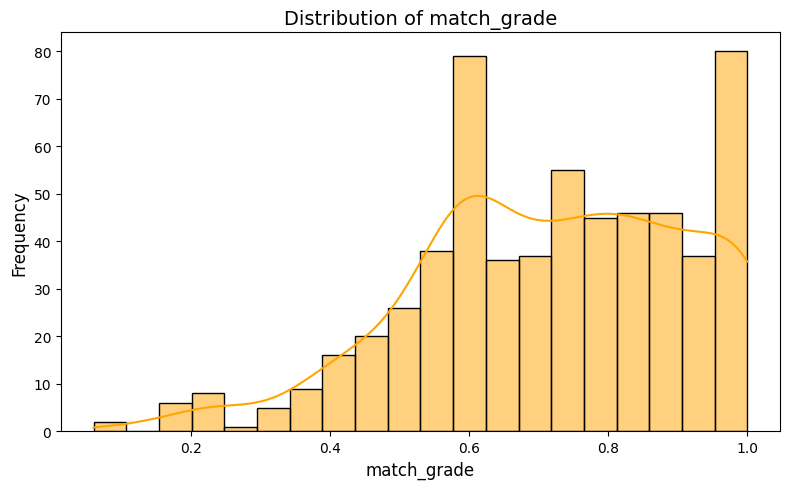

In [361]:
plt.figure(figsize=(8, 5))
sns.histplot(df_best_matches['match_grade'], bins=20, kde=True, color='orange', ec='black')
plt.title('Distribution of match_grade', fontsize=14)
plt.xlabel('match_grade', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

The histogram above illustrates the distribution of `match_grade` values across all matched records. The curve overlay (KDE) helps visualize the density and frequency of matching quality:

- The distribution is **right-skewed**, with a concentration of values towards the higher end of the scale (close to 1.0).
- This indicates that a significant portion of the entity matches received **high match grades**, reflecting strong alignment between input data and candidate records.
- A smaller tail on the left suggests fewer low-confidence matches.

This visualization reinforces that the majority of matches are of high quality, aligning well with the confidence labeling.


In [375]:
confidence_distribution = df_best_matches['match_confidence'].value_counts().to_frame(name='count')
confidence_distribution['percentage'] = (confidence_distribution['count'] / confidence_distribution['count'].sum() * 100).round(2)

print("\nDistribution of Confidence Labels:")
print(confidence_distribution)


Distribution of Confidence Labels:
                      count  percentage
match_confidence                       
Very High Confidence    210       35.47
Moderate Confidence     119       20.10
High Confidence         111       18.75
Low Confidence           69       11.66
No Match                 42        7.09
Very Low Confidence      41        6.93


Distribution of Match Confidence Labels

| Match Confidence       | Count | Percentage (%) |
|------------------------|-------|----------------|
| Very High Confidence   | 210   | 35.47%         |
| Moderate Confidence    | 119   | 20.10%         |
| High Confidence        | 111   | 18.75%         |
| Low Confidence         | 69    | 11.66%         |
| No Match               | 42    | 7.09%          |
| Very Low Confidence    | 41    | 6.93%          |

  Most matches fall into the "High" or "Very High" confidence levels, indicating good model performance.

   Approximately 14% of the records are in "Low" or "Very Low" confidence, which may require manual review.

   7% are labeled as "No Match" — suggesting either data sparsity or unmatched entities.

C:\Users\user\AppData\Local\Temp\ipykernel_26744\3278172123.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


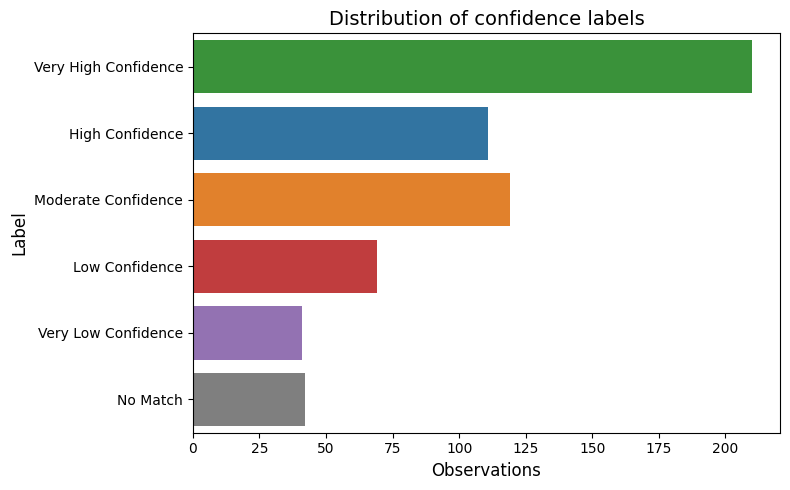

In [379]:
order = [
    'Very High Confidence',
    'High Confidence',
    'Moderate Confidence',
    'Low Confidence',
    'Very Low Confidence',
    'No Match'
]

palette = {
    'Very High Confidence': '#2ca02c',   
    'High Confidence': '#1f77b4',        
    'Moderate Confidence': '#ff7f0e',    
    'Low Confidence': '#d62728',         
    'Very Low Confidence': '#9467bd',    
    'No Match': '#7f7f7f'                
}

plt.figure(figsize=(8, 5))
sns.countplot(
    y='match_confidence',
    data=df_best_matches,
    order=order,
    palette=palette
)

plt.title('Distribution of confidence labels', fontsize=14)
plt.xlabel('Observations', fontsize=12)
plt.ylabel('Label', fontsize=12)
plt.tight_layout()
plt.show()


The horizontal bar chart shows the distribution of records by their assigned `match_confidence` labels. These labels were derived from the final weighted `match_grade` values:

- **Very High Confidence** dominates the distribution, suggesting that many records were matched with excellent certainty.
- Moderate and High Confidence labels also contribute significantly, reflecting generally reliable matches.
- A smaller number of records fall into Low or Very Low Confidence, which might warrant further review.
- A limited number of entries were classified as **No Match**, indicating no suitable candidate was found.

In [376]:
country_avg = (
    df_best_matches
    .groupby('input_main_country')['match_grade']
    .agg(['count', 'mean', 'min', 'max'])
    .round(3)
    .reset_index()
    .rename(columns={'mean': 'avg_match_grade'})
)

print(country_avg.sort_values('avg_match_grade', ascending=False).head(10))

   input_main_country  count  avg_match_grade   min   max
33      united states     23            0.826  0.37  1.00
26        south korea      1            0.820  0.82  0.82
3               china     14            0.816  0.50  1.00
16         luxembourg      1            0.800  0.80  0.80
10            hungary      3            0.793  0.56  0.92
24             serbia      1            0.770  0.77  0.77
29        switzerland      5            0.768  0.52  1.00
6             finland     12            0.762  0.30  1.00
20             norway     91            0.761  0.20  1.00
7              france      6            0.752  0.46  1.00


The code computes summary statistics of the `match_grade` for each country:

- It groups the dataset (`df_best_matches`) by `input_main_country`.
- For each group, it calculates the **count**, **mean**, **minimum**, and **maximum** of the `match_grade`.
- The mean is renamed to `avg_match_grade` and results are rounded to 3 decimal.
- Finally, the top 10 countries are displayed in descending order of average match grade.

This helps identify which countries yield the highest overall match quality based on the computed grades.

C:\Users\user\AppData\Local\Temp\ipykernel_26744\3341004973.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10,


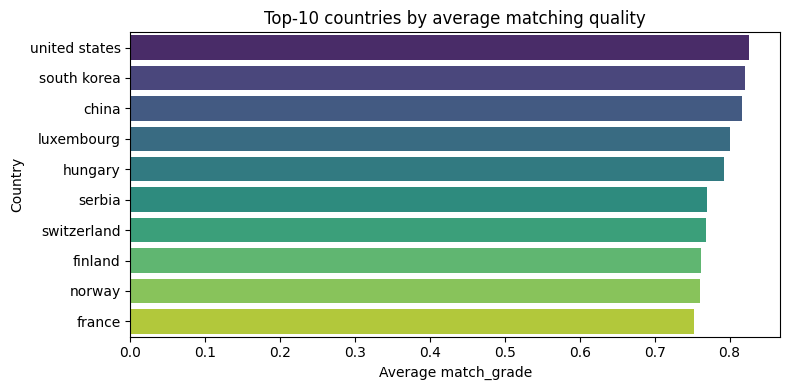

In [377]:
top10 = country_avg.nlargest(10, 'avg_match_grade')

plt.figure(figsize=(8,4))
sns.barplot(data=top10,
            x='avg_match_grade',
            y='input_main_country',
            palette='viridis')
plt.xlabel('Average match_grade')
plt.ylabel('Country')
plt.title('Top-10 countries by average matching quality')
plt.tight_layout()
plt.show()

This visualization highlights the top 10 countries with the highest average `match_grade` scores.  
This helps identify regions where the matching algorithm performs most confidently and consistently.

C:\Users\user\AppData\Local\Temp\ipykernel_26744\2265198166.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


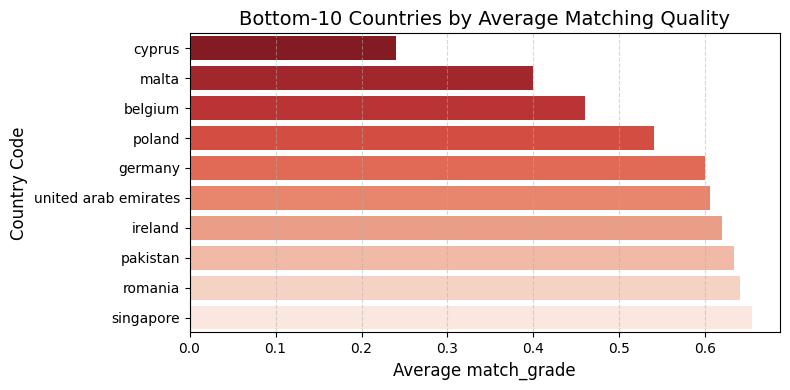

In [378]:
bottom10 = country_avg.nsmallest(10, 'avg_match_grade')

plt.figure(figsize=(8, 4))
sns.barplot(
    data=bottom10,
    x='avg_match_grade',
    y='input_main_country',
    palette='Reds_r'

)
plt.xlabel('Average match_grade', fontsize=12)
plt.ylabel('Country Code', fontsize=12)
plt.title('Bottom-10 Countries by Average Matching Quality', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Simillarly, this chart presents the ten countries with the lowest average `match_grade` scores, providing insight into regions where the entity resolution model demonstrates weaker performance.

In [367]:
# Finding all the duplicated rows for veridion_id
duplicate_rows = df_best_matches[df_best_matches.duplicated(
    subset='veridion_id', keep=False)
]

print(duplicate_rows)

      input_row_key                             input_company_name  \
1886             44       apple distribution international limited   
1943             45       apple distribution international limited   
180             130                       deloitte advokatfirma as   
186             131                                    deloitte as   
222             138                      dial zero private limited   
229             139                                nets denmark as   
318             155                        eci media management ab   
321             156                        eci media management ab   
618             209                        google commerce limited   
625             210                         google ireland limited   
830             248                                 hubersuhner ag   
836             249        hubersuhner electronics private limited   
884             257                         imi mobile vas limited   
885             258 

The purpose of this code block is to identify potential inconsistencies in the matching logic by finding all duplicate entries based on the `veridion_id`.

In [368]:
# For each duplicated veridion_id we select the row with the highest match_grade
best_duplicates = (
    duplicate_rows
    .sort_values('match_grade', ascending=False)         
    .drop_duplicates(subset='veridion_id', keep='first') 
)

# Rows that contain no duplicates
unique_rows = df_best_matches[~df_best_matches['veridion_id']
                              .isin(duplicate_rows['veridion_id'])]

# Concatenating the unique_rows with the best duplicates  
df_cleaned_best = pd.concat([unique_rows, best_duplicates], ignore_index=True)

print(f"Rows before de-duplication : {len(df_best_matches)}")
print(f"Rows after  de-duplication : {len(df_cleaned_best)}")

Rows before de-duplication : 592
Rows after  de-duplication : 580


To ensure that each `veridion_id` appears only once in the final dataset, this step resolves duplicates by keeping only the best match — the one with the highest `match_grade`.

  For each duplicated `veridion_id`, the code retains only the row with the highest `match_grade`. This ensures that the strongest candidate is selected when multiple possible matches exist.

  Rows that are not duplicated (i.e., have a unique `veridion_id`) are retained without any changes.

  The selected best duplicates are combined with the unique rows to form a clean dataset (`df_cleaned_best`) without any repeated `veridion_id`s.


  ***Result***: The total number of rows is reduced, eliminating redundancy while preserving the most relevant match for each company. This step improves both the accuracy and interpretability of the final matching output.

In [369]:
# How many missing values are in each column
missing_values = df_cleaned_best.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Count']

# Percentage of missing
missing_values['Missing %'] = (
    missing_values['Missing Count'] / len(df_cleaned_best) * 100
).round(2)

missing_values = missing_values.sort_values(by='Missing %', ascending=False)

print(missing_values.head(10))


                        Column  Missing Count  Missing %
72                  tiktok_url            580     100.00
37  naics_2022_secondary_codes            527      90.86
25                year_founded            287      49.48
26                     revenue            233      40.17
28              employee_count            220      37.93
21              main_longitude            169      29.14
20               main_latitude            169      29.14
56               primary_phone            124      21.38
35     naics_2022_primary_code             84      14.48
23               num_locations             14       2.41


Missing Values Overview

Below is a summary of the top 15 variables with the highest percentage of missing values in the final cleaned dataset:

| Column                       | Missing Count | Missing % |
|-----------------------------|---------------|------------|
| `tiktok_url`                | 580           | 100.00%    |
| `naics_2022_secondary_codes`| 562           | 90.86%     |
| `year_founded`              | 287           | 49.48%     |
| `revenue`                   | 233           | 40.14%     |
| `employee_count`            | 220           | 37.93%     |
| `main_longitude`            | 169           | 29.14%     |
| `main_latitude`             | 169           | 29.14%     |
| `primary_phone`             | 124           | 21.38%     |
| `naics_2022_primary_code`   | 61            | 10.30%     |
| `num_locations`             | 14            | 2.41%      |


Observations:
- `tiktok_url` and `naics_2022_secondary_codes` are nearly or completely missing and may not be useful for modeling or analysis.
- Core business attributes such as `revenue`, `employee_count`, and `year_founded` have moderate missingness (~40–50%) and might require imputation or special handling.
- All input reference fields are complete, indicating good quality on the input side.

### 5. Exporting the Final Cleaned Dataset

This section prepares the final cleaned dataset, ready for export. The steps include:

Removing unnecessary columns:
We drop technical columns such as those ending in _score, _grade, and tiktok_url to reduce noise and file size.

Standardizing IDs for merging:
The veridion_id is cleaned of hyphens (-) in both the working DataFrame and the original, to allow consistent joins.

Extracting social & web URL columns:
From the original dataset, we extract relevant URL fields (e.g., website_url, linkedin_url, etc.), as they may contain real links not preserved in processed DataFrames.

Merging back enriched URLs:
The clean final dataset is enriched with these URLs through a left join using the cleaned veridion_id.

Final cleanup:
The temporary veridion_id_clean column is dropped, and a preview of the cleaned final dataset is displayed.

In [370]:
columns_to_drop = [
    col for col in df_cleaned_best.columns
    if col.endswith('_score') or col.endswith('_grade') or col == 'tiktok_url'
]

# Creating a new df without the score and grade related columns
df_final_export = df_cleaned_best.drop(columns=columns_to_drop)

df['veridion_id_clean'] = df['veridion_id'].astype(str).str.replace("-", "")
df_final_export['veridion_id_clean'] = df_final_export['veridion_id'].astype(str).str.replace("-", "")

url_columns = [
    "website_url", "facebook_url", "twitter_url", "instagram_url", "linkedin_url",
    "ios_app_url", "android_app_url", "youtube_url"
]

# Extracting only the columns refereing to URLs
df_urls = df[['veridion_id_clean'] + url_columns].drop_duplicates('veridion_id_clean')

df_final_export = df_final_export.drop(columns=url_columns, errors='ignore')  # În caz că le aveam deja
df_final_export = df_final_export.merge(df_urls, on="veridion_id_clean", how="left")

df_final_export.drop(columns=['veridion_id_clean'], inplace=True)

# Quick Check
df_final_export.head(15)

,input_row_key,input_company_name,input_main_country_code,input_main_country,input_main_region,input_main_city,input_main_postcode,input_main_street,input_main_street_number,veridion_id,...,last_updated_at,match_confidence,website_url,facebook_url,twitter_url,instagram_url,linkedin_url,ios_app_url,android_app_url,youtube_url
0,0,24seven media network private limited,pk,pakistan,sindh,karachi,nan,nan,nan,26e2221093e511ebb9978dd98d09cf25,...,20241129t041800109z,High Confidence,https://www.mnet.com.pk/,NaN,NaN,NaN,http://www.linkedin.com/company/mnet-services-...,NaN,NaN,NaN
1,1,2operate as,dk,denmark,north denmark region,aalborg,9220,niels jernes vej,10,8b99ef8393e411ebb9978dd98d09cf25,...,20250328t151632101z,Very High Confidence,https://www.2operate.com/,NaN,NaN,NaN,https://www.linkedin.com/company/2operate-as,NaN,NaN,NaN
2,2,3 step it as,dk,denmark,region of southern denmark,tnder municipality,nan,nan,nan,45309031f8ab11ed89fe613148a94f23,...,20250416t154706888z,Moderate Confidence,http://www.3stepit.dk/?opi=79508299&sa=U&ved=0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3 step it as,no,norway,oslo,oslo,167,wergelandsveien,7,08f48bc272c911ec96d11d653dff9d1b,...,20241104t180847000z,Moderate Confidence,https://iscy.no/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3 step it sweden ab,se,sweden,stergtland county,linkping,581 15,nan,nan,e5cede70040911eda83d25d09483d16d,...,20250418t045446762z,Very Low Confidence,http://www.proact.se/,https://www.facebook.com/ProactGroup/,https://twitter.com/proact_it,NaN,http://www.linkedin.com/company/proact-it-swed...,NaN,NaN,https://www.youtube.com/channel/UC87kltvgz8CrX...
5,5,3degrees group inc,us,united states,california,san francisco,94104,montgomery street,235,df61d79093e411ebaa669b8d95e2171b,...,20250417t022836847z,Very High Confidence,http://3degreesinc.com/,https://www.facebook.com/3DegreesInc/,https://twitter.com/3Degrees_Inc,https://www.instagram.com/3degreesinc_/,https://www.linkedin.com/company/3degrees,NaN,NaN,https://www.youtube.com/channel/UC7voGEfqAPksg...
6,6,3step it group oy,fi,finland,uusimaa,helsinki,180,mechelininkatu,1a,359bd11693e511ebb5f6816dd10ac7b0,...,20250420t223251098z,Very High Confidence,https://sg.3stepit.com/,https://www.facebook.com/3stepIT/,https://twitter.com/3StepITSverige,https://www.instagram.com/3stepitsuomi/,https://www.linkedin.com/showcase/3stepitsverige,NaN,NaN,https://www.youtube.com/channel/UCt5D7f5P0J_Oq...
7,7,at kearney ab,se,sweden,nan,nan,nan,nan,nan,94cef5f993e411eb8e19198fb02d6f96,...,20250118t164302000z,Very Low Confidence,https://www.kearney.in/,https://www.facebook.com/kearney/,https://twitter.com/kearney,https://www.instagram.com/kearneyofficial/,https://www.linkedin.com/company/kearney,NaN,NaN,https://www.youtube.com/kearneyofficial
8,8,a t kearney pte ltd,sg,singapore,nan,nan,nan,nan,nan,4f44b02e17aa11f087dc2b7a69541cf4,...,20250209t070153000z,No Match,https://atkearney.top/#/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,aalborg city,dk,denmark,north denmark region,aalborg,9000,lille kongensgade,6,272b871193e511eb8e19198fb02d6f96,...,20241129t030324897z,Very High Confidence,https://aalborgcity.dk/,https://www.facebook.com/aalborgcity/,NaN,https://www.instagram.com/aalborgcity/,https://dk.linkedin.com/company/aalborg-city,NaN,NaN,NaN


In [371]:
df_final_export.to_csv("df_final_export_ready.csv", index=False)
print("Exported df_final_export_ready.csv with URLs correctly restored.")

Exported df_final_export_ready.csv with URLs correctly restored.
